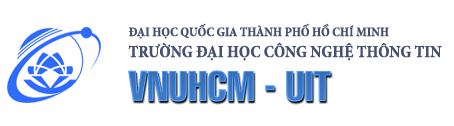

`Môn học: Truy vấn thông tin đa phương tiện - CS336.O11`

`Chủ đề: Multi-Stage Document Ranking for Vietnamese News Retrieval`

`GV hướng dẫn: ThS. Đỗ Văn Tiến`

`Thành viên nhóm:`

`Nguyễn Trung Kiên - 21521024`

`Phạm Quốc Việt - 21522792`

# `Giới thiệu bài toán`

`Đặt vấn đề: Cho một truy vấn q và một ngữ liệu D là tập hợp nhiều bài
báo khác nhau, trong đó mỗi bài báo bao gồm tiêu đề (title) và tổng quan
(abstract). Hãy xây dựng một hệ thống truy vấn giúp trả về các bài báo từ
D thỏa mãn:`

`1. Chứa các ngữ cảnh quan trọng liên quan đến q.`

`2. Ranking: Xếp hạng các bài báo từ trên xuống dưới dựa vào độ đo nào
đó nhằm thể hiện mức độ liên quan với truy vấn.`


# `1. Import packages`

In [ ]:
#import needed libraries
!pip install transformers
!pip install py_vncorenlp
!pip install rank_bm25
import requests
import re
from bs4 import BeautifulSoup
import py_vncorenlp
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.6 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4307 sha256=78b4ef0a24f66d8548338e498c0cebf5dfaa8c32733e821f19ad6568388bdbeb
  Stored in directory: /root/.cache/pip/wheels/d5/d9/bf/62632cdb007c702a0664091e92a0bb1f18a2fcecbe962d9827
Successfully built py_vncorenlp


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Automatically download VnCoreNLP components from the original repository
# and save them in some local machine folder
py_vncorenlp.download_model(save_dir = "/content/drive/MyDrive/py_vncorenlp")
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/drive/MyDrive/py_vncorenlp')

VnCoreNLP model folder /content/drive/MyDrive/py_vncorenlp already exists! Please load VnCoreNLP from this folder!


In [ ]:
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

# `2. Data processing + Query input`

## `2.1. Lấy dữ liệu`

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ArticlesNewspaper.csv', header = 0, sep='\t', encoding= 'utf-16')

In [ ]:
data

,title,abstract,source,link,topic,time,imglink
0,Thành nhà Hồ miễn phí tham quan nhân Ngày di s...,Thanh Hóa - Nhân kỷ niệm 18 năm ngày Di sản vă...,Báo Lao Động,https://laodong.vn/xa-hoi/thanh-nha-ho-mien-ph...,Xã hội,21/11/2023 17:20,https://media-cdn-v2.laodong.vn/storage/newspo...
1,Ngang nhiên thu phí tại cầu phao đã bị cấm hoạ...,Thái Nguyên - Mặc dù đã bị cấm hoạt động hơn m...,Báo Lao Động,https://laodong.vn/xa-hoi/ngang-nhien-thu-phi-...,Xã hội,21/11/2023 17:08,https://media-cdn-v2.laodong.vn/storage/newspo...
2,"Trong 10 tháng, Cần Thơ xảy ra 39 vụ sạt lở gâ...","Cần Thơ - So với cùng kỳ năm 2022, trong 10 th...",Báo Lao Động,https://laodong.vn/xa-hoi/trong-10-thang-can-t...,Xã hội,21/11/2023 16:48,https://media-cdn-v2.laodong.vn/storage/newspo...
3,Hiện trạng nút giao đang thí điểm bỏ đèn giao ...,Nút giao Châu Văn Liêm - Lê Quang Đạo - Mễ Trì...,Báo Lao Động,https://laodong.vn/video-xa-hoi/hien-trang-nut...,Xã hội,21/11/2023 16:44,https://media-cdn-v2.laodong.vn/storage/newspo...
4,Dự án chống ùn tắc hơn 800 tỉ đồng ở Hà Nội sa...,"Hà Nội - Khởi công cuối năm 2019, Dự án mở rộn...",Báo Lao Động,https://laodong.vn/photo/du-an-chong-un-tac-ho...,Xã hội,21/11/2023 16:38,https://media-cdn-v2.laodong.vn/storage/newspo...
...,...,...,...,...,...,...,...
49537,Tổ chức thành công kỳ thi tốt nghiệp THPT là n...,(ĐCSVN) - Đó là nhấn mạnh của các đồng chí: Ng...,Báo Đảng Cộng Sản,https://dangcongsan.vn/giao-duc/to-chuc-thanh-...,Giáo dục,1/7/2021 14:41,https://file1.dangcongsan.vn/data/0/images/202...
49538,Học tập và làm theo Bác về tinh thần tự học,"(ĐCSVN) - Toàn tâm, toàn ý tự học để phục vụ n...",Báo Đảng Cộng Sản,https://dangcongsan.vn/giao-duc/hoc-tap-va-lam...,Giáo dục,30/06/2021 16:08,https://file1.dangcongsan.vn/data/0/images/202...
49539,Đề xuất phương án xét tuyển một lần cho cả 2 đ...,"(ĐCSVN) - Ngày 30/6, PGS.TS Nguyễn Thu Thủy, V...",Báo Đảng Cộng Sản,https://dangcongsan.vn/giao-duc/de-xuat-phuong...,Giáo dục,30/06/2021 15:09,https://file1.dangcongsan.vn/data/0/images/202...
49540,"Bộ GD&ĐT yêu cầu xác minh, xử lý vụ việc “cháu...",(ĐCSVN) - Ngay sau khi nắm bắt thông tin về cl...,Báo Đảng Cộng Sản,https://dangcongsan.vn/giao-duc/bo-gd-dt-yeu-c...,Giáo dục,30/06/2021 14:33,https://file1.dangcongsan.vn/data/0/images/202...


In [ ]:
data.head()

,title,abstract,source,link,topic,time,imglink
0,Thành nhà Hồ miễn phí tham quan nhân Ngày di s...,Thanh Hóa - Nhân kỷ niệm 18 năm ngày Di sản vă...,Báo Lao Động,https://laodong.vn/xa-hoi/thanh-nha-ho-mien-ph...,Xã hội,21/11/2023 17:20,https://media-cdn-v2.laodong.vn/storage/newspo...
1,Ngang nhiên thu phí tại cầu phao đã bị cấm hoạ...,Thái Nguyên - Mặc dù đã bị cấm hoạt động hơn m...,Báo Lao Động,https://laodong.vn/xa-hoi/ngang-nhien-thu-phi-...,Xã hội,21/11/2023 17:08,https://media-cdn-v2.laodong.vn/storage/newspo...
2,"Trong 10 tháng, Cần Thơ xảy ra 39 vụ sạt lở gâ...","Cần Thơ - So với cùng kỳ năm 2022, trong 10 th...",Báo Lao Động,https://laodong.vn/xa-hoi/trong-10-thang-can-t...,Xã hội,21/11/2023 16:48,https://media-cdn-v2.laodong.vn/storage/newspo...
3,Hiện trạng nút giao đang thí điểm bỏ đèn giao ...,Nút giao Châu Văn Liêm - Lê Quang Đạo - Mễ Trì...,Báo Lao Động,https://laodong.vn/video-xa-hoi/hien-trang-nut...,Xã hội,21/11/2023 16:44,https://media-cdn-v2.laodong.vn/storage/newspo...
4,Dự án chống ùn tắc hơn 800 tỉ đồng ở Hà Nội sa...,"Hà Nội - Khởi công cuối năm 2019, Dự án mở rộn...",Báo Lao Động,https://laodong.vn/photo/du-an-chong-un-tac-ho...,Xã hội,21/11/2023 16:38,https://media-cdn-v2.laodong.vn/storage/newspo...


In [ ]:
titles = data['title']
abstracts = data['abstract']
titles

0        Thành nhà Hồ miễn phí tham quan nhân Ngày di s...
1        Ngang nhiên thu phí tại cầu phao đã bị cấm hoạ...
2        Trong 10 tháng, Cần Thơ xảy ra 39 vụ sạt lở gâ...
3        Hiện trạng nút giao đang thí điểm bỏ đèn giao ...
4        Dự án chống ùn tắc hơn 800 tỉ đồng ở Hà Nội sa...
                               ...                        
49537    Tổ chức thành công kỳ thi tốt nghiệp THPT là n...
49538          Học tập và làm theo Bác về tinh thần tự học
49539    Đề xuất phương án xét tuyển một lần cho cả 2 đ...
49540    Bộ GD&ĐT yêu cầu xác minh, xử lý vụ việc “cháu...
49541    Đảm bảo cấp điện cho thi tốt nghiệp THPT tại m...
Name: title, Length: 49542, dtype: object

## `2.2. Phân tích dữ liệu`

`Có thể thấy tổng số lượng các bài báo đã được craft là 49542. Số lượng của từng bài báo được lấy như sau`

In [ ]:
data['source'].value_counts(sort = False)

Báo Lao Động          7434
Báo Dân Trí           8003
Báo VnExpress         4560
Báo VTC               9876
Báo Đảng Cộng Sản    19669
Name: source, dtype: int64

` Số lượng các bài báo tương ứng với mỗi loại chủ đề`

In [ ]:
data['topic'].value_counts(sort = False)

Xã hội                  3841
Thể thao                2451
Văn hóa                 3498
Kinh doanh              1597
Thế giới                7124
Thời sự                 6380
Công đoàn                932
Giải trí                2914
Bất động sản            1113
Lao động và việc làm     560
Tấm lòng nhân ái         534
Sức khỏe                1511
Xe                      1908
Giáo dục                4126
Pháp luật               4092
Công nghệ               1465
Khoa học                1648
Đời sống                  40
Du lịch                   50
Kinh tế                 2833
Phóng sự                 889
Khám phá                  36
Name: topic, dtype: int64

In [ ]:
datee = pd.to_datetime(data['time'])
print(str(datee.min()) + " " + str(datee.max()))

2017-01-04 11:27:00 2023-12-11 23:59:00


## `2.3. Preprocessing`

### `2.3.1. Lowercasing`

In [ ]:
def lower_text(text):
    ptext = text.lower()
    return ptext

In [ ]:
pfi = [lower_text(titles[i]) + " " + lower_text(str(abstracts[i])) for i in range(len(titles))]
pfi[0]

'thành nhà hồ miễn phí tham quan nhân ngày di sản việt nam thanh hóa - nhân kỷ niệm 18 năm ngày di sản văn hoá việt nam (23.11.2005 - 23.11.2023), trung tâm bảo tồn di sản thành nhà hồ sẽ miễn tham...'

### `2.3.2. Segmentation`

In [ ]:
def segment_text(text):
  text = rdrsegmenter.word_segment(text)
  return str(text)

In [ ]:
pfi = [segment_text(word) for word in pfi]
pfi[0]

"['thành nhà hồ miễn_phí tham_quan nhân ngày di_sản việt_nam thanh_hoá - nhân kỷ_niệm 18 năm ngày di_sản văn_hoá việt_nam ( 23.11.2005 - 23.11.2023 ) , trung_tâm bảo_tồn di_sản thành nhà hồ sẽ miễn tham ...']"

### `2.3.3. Loại bỏ stopwords`

In [ ]:
#link : "https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords-dash.txt"
stopwords= open('/content/drive/MyDrive/vietnamese-stopwords-dash.txt','r',encoding='utf-8').read().split("\n")

In [ ]:
def remove_stopwords(stopwords, title):
  tokenized_title = title.split(' ')
  fi_title_words = []
  for word in tokenized_title:
    if word not in stopwords:
      fi_title_words.append(word)
  fi_title = ' '.join(fi_title_words)
  return fi_title

In [ ]:
pfi = [remove_stopwords(stopwords, word) for word in pfi]

### `2.3.4. Loại bỏ các ký tự đặc biệt`

In [ ]:
#Danh sách các ký tự đặc biệt
special_characters = [
    '!', '"', '#', '$', '%', '&', "'", '(', ')', '*',
    '+', ',', '-', '.', '/', ':', ';', '<', '=', '>',
    '?', '@', '[', '\\', ']', '^', '`', '{', '|',
    '}', '~'
]

In [ ]:
#Lọc ký tự đặc biệt
def remove_special_characters(title):
    cleaned_title = ''.join(char for char in title if char not in special_characters)
    return cleaned_title

In [ ]:
prpfi = [remove_special_characters(title) for title in pfi]

In [ ]:
print(prpfi[20146])

dự_báo thời_tiết tphcm hôm_nay 1511  chiều mưa_rào rải_rác thời_tiết tphcm hôm_nay 1511  chiều_tối đêm mưa_rào dông rải_rác 


#`3. Multi-stage Document Ranking`

`Phương pháp` **`Multi-stage Document Ranking`**`: Thay vì sử dụng một mô hình đơn lẻ để xếp hạng tất cả các tài liệu, multi-stage document ranking áp dụng một chuỗi các mô hình khác nhau, mỗi mô hình thực hiện một chức năng cụ thể. Hướng thực hiện của nhóm sẽ là sử dụng một \textbf{phương pháp term-based} như TF-IDF hay BM25 để lọc các bài báo có nội dung không liên quan, các kết quả được lọc ra từ các phương pháp term-based sẽ được đưa vào một mô hình ngôn ngữ được đào tạo trước (pre-trained language model) để xét về mặt ngữ nghĩa văn bản. `

`Hình dưới là Pineline xử lý của Multi-stage Document Ranking do nhóm đề xuất:`

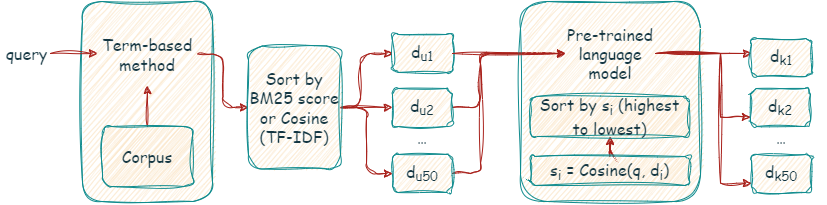

`Giải thích: query và tập ngữ liệu sau khi được tiền xử lý sẽ được đưa qua các phương pháp term-based, ta lấy ra 50 bài báo có BM25 score cao nhất khi sử dụng BM25, hoặc cosine cao nhất khi sử dụng TF-IDF. 50 bài báo này sẽ được reranking lại một lần nữa qua mô hình pre-trained để có được danh sách cuối cùng.`

`Trong phần 4 và 5, nhóm sẽ sử dụng BM25 và PhoBERT để minh họa cho phương pháp.`

# `4: BM25`



In [ ]:
tokenized_corpus = [doc.split(" ") for doc in prpfi]

In [ ]:
#Nhập query
query = input()

tình hình thể thao trong nước


In [ ]:
pquery = remove_special_characters(remove_stopwords(stopwords, segment_text(lower_text(query))))
pquery

'tình_hình thể_thao nước'

In [ ]:
#final_query = get_weighted_query(pquery, tokenized_corpus)
#print(final_query)
final_query = pquery

In [ ]:
bm25 = BM25Okapi(tokenized_corpus)
bm25

In [ ]:
bmquery = final_query.split(" ")
print(bmquery)
doc_scores = bm25.get_scores(bmquery)

['tình_hình', 'thể_thao', 'nước']


In [ ]:
BM25_list50_content = bm25.get_top_n(bmquery, prpfi, n=50)
content_sorted_indices = sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)
BM25_list50_titles = bm25.get_top_n(bmquery, titles, n=50)
BM25_list50_titles

['Nước lá đinh lăng có tốt?',
 'Nước quất hay nước chanh tốt hơn?',
 'Những dấu ấn thể dục, thể thao nổi bật 6 tháng đầu năm',
 'Nước nào từng mời Albert Einstein làm tổng thống?',
 'Nước ép khế ngọt có tác dụng gì?',
 "Nước vối rất tốt nhưng lại 'đại kỵ' với những nhóm người sau",
 'Nước nào có quốc kỳ không phải hình chữ nhật?',
 "Nước lá tía tô rất tốt nhưng lại 'đại kỵ' với 3 nhóm người sau",
 'Nước rửa kính ô tô có độc hại?',
 'Thực hiện các nguyên tắc tập luyện TDTT phòng chống COVID-19',
 "Nước vối ngon mát nhưng lại 'đại kỵ' với 6 nhóm người này",
 'Nước thành viên chặn viện trợ quân sự của EU cho Ukraina',
 'Nước hầm xương có tốt?',
 'Nước nào chỉ tiếp giáp với Nga và Trung Quốc?',
 'Nước nhỏ giọt dưới gầm ô tô do đâu?',
 'Nước vỏ bưởi có công dụng gì cho sức khỏe?',
 'Nước giàu nhất châu Âu khủng hoảng bất động sản',
 'Nước EU ra quyết định lịch sử về tài sản bị đóng băng của Nga',
 'Nước thành viên EU muốn mở rộng kinh doanh tại Nga',
 "Nước dừa giải nhiệt tốt nhưng lại 'đại

#`5. PhoBERT`

## `5.1. pooled_output token [CLS]`

`Tìm kiếm ngữ nghĩa, kết hợp sức mạnh của BM25 + PhoBERT`

In [ ]:
data_ws = list()
for col in BM25_list50_content:
  data_ws.append(str(col))
data_ws[0]

'nước lá đinh_lăng  đun lá đinh_lăng uống  lá đinh_lăng '

In [ ]:
input_ids = torch.tensor([tokenizer.encode(data_ws[0])])

with torch.no_grad():
    databert = phobert(input_ids).pooler_output.numpy()

In [ ]:
for i in range(1, len(data_ws)):
  val_ids = torch.tensor([tokenizer.encode(data_ws[i])])
  with torch.no_grad():
    databert = np.vstack([databert, phobert(val_ids).pooler_output.numpy().flatten()])

In [ ]:
print(databert)

[[-0.0226402  -0.06991316  0.02468598 ...  0.15260863  0.04551969
   0.09155262]
 [-0.07848582 -0.11447006  0.11680827 ...  0.15457352 -0.02294064
   0.14417012]
 [-0.3298344   0.02299169 -0.22849043 ... -0.08270417  0.18376216
  -0.02253758]
 ...
 [-0.20197499  0.03564495 -0.04342284 ... -0.07073653  0.05647289
  -0.04466664]
 [-0.28206947 -0.02291859 -0.16167231 ... -0.19477421 -0.04634547
  -0.0976665 ]
 [-0.2549479   0.11898652 -0.04605354 ...  0.00209448 -0.0485031
  -0.14422835]]


In [ ]:
databert.shape

(50, 768)

In [ ]:
phoquery = final_query
print(phoquery)
#encoded the query
cv_query = torch.tensor([tokenizer.encode(str(phoquery))])
with torch.no_grad():
  cv_query = phobert(cv_query).pooler_output.numpy().flatten()

tình_hình thể_thao nước


In [ ]:
cossimilarity = []
for i in range(databert.shape[0]):
  cossimilarity.append(databert[i,:].dot(cv_query) / (np.linalg.norm(databert[i,:]) * np.linalg.norm(cv_query)))
print(cossimilarity)

[0.628465, 0.5547348, 0.6900471, 0.64656615, 0.59024274, 0.6587224, 0.6545547, 0.6789496, 0.6504984, 0.71517146, 0.6546394, 0.6714707, 0.7035909, 0.661669, 0.6155883, 0.59385586, 0.6635681, 0.67815953, 0.6452897, 0.6164309, 0.6829149, 0.7239185, 0.6506793, 0.601149, 0.67177373, 0.71696514, 0.65759206, 0.6849852, 0.7107069, 0.62625545, 0.62194633, 0.6984506, 0.653165, 0.6942743, 0.57523096, 0.7225196, 0.6716436, 0.6570775, 0.64183736, 0.7034036, 0.659936, 0.59146947, 0.73734766, 0.69196355, 0.64865386, 0.6531518, 0.71695983, 0.6757054, 0.6623815, 0.6505964]


In [ ]:
# Sử dụng cosine similarity
sorted_ids_data = np.argsort(np.array(cossimilarity))
sorted_ids = sorted_ids_data[::-1]
k = 10
k_idx = sorted_ids[0: k]
print(k_idx)

[42 21 35 25 46  9 28 12 39 31]


## `5.2. 10 kết quả tốt nhất`

In [ ]:
print(content_sorted_indices[:])

[26918, 27112, 44157, 18521, 18576, 26632, 26716, 26653, 28141, 44096, 4645, 26322, 26521, 4441, 16842, 18315, 26558, 28193, 4214, 4661, 26618, 26927, 4698, 26645, 20493, 4436, 4563, 13435, 26997, 26505, 26602, 18367, 21512, 43529, 26862, 397, 13735, 43508, 43485, 43810, 43562, 42766, 1545, 476, 7712, 20144, 1271, 42339, 43263, 18611, 40618, 43532, 43547, 43953, 44111, 42858, 44272, 42585, 43329, 312, 20537, 43889, 42978, 7593, 1591, 15010, 42609, 42834, 44167, 44125, 10115, 43763, 23194, 42322, 43002, 43034, 44057, 23191, 23357, 44280, 885, 7553, 20017, 5551, 43843, 43550, 20013, 42831, 35567, 44139, 34008, 11577, 23091, 15378, 42568, 26002, 31843, 35631, 43186, 44143, 10195, 42270, 42517, 42709, 43138, 43470, 44289, 22470, 22613, 27758, 28796, 35226, 42778, 43140, 43878, 44199, 5381, 983, 43169, 43173, 10197, 34669, 42939, 42944, 43179, 42872, 42716, 43501, 44152, 48309, 6079, 12216, 7070, 28692, 28883, 43358, 43657, 42511, 42532, 42887, 43463, 44025, 44036, 43378, 31613, 43641, 4389

In [ ]:
cnt = 1
for i in k_idx:
  print('rank '+ str(cnt) + ' is the article name: ' + BM25_list50_titles[i] + ' , cosine: ' + str(cossimilarity[i]) + ' , position: ' + str(content_sorted_indices[i]))
  cnt += 1

rank 1 is the article name: Tìm hướng đi phù hợp cho thể thao Việt Nam , cosine: 0.73734766 , position: 1545
rank 2 is the article name: Nước tiêu thụ dầu lớn thứ 3 thế giới công bố chính sách dầu mỏ , cosine: 0.7239185 , position: 26927
rank 3 is the article name: Nước lũ dâng cao, học sinh chòng chành trên đò đến trường , cosine: 0.7225196 , position: 397
rank 4 is the article name: Nước nào nhập khẩu nhiều ô tô Trung Quốc nhất? , cosine: 0.71696514 , position: 4436
rank 5 is the article name: Chờ thông điệp định hướng cho thể thao Việt Nam , cosine: 0.71695983 , position: 1271
rank 6 is the article name: Thực hiện các nguyên tắc tập luyện TDTT phòng chống COVID-19 , cosine: 0.71517146 , position: 44096
rank 7 is the article name: Nước qua máy lọc có nên đun sôi? , cosine: 0.7107069 , position: 26997
rank 8 is the article name: Nước hầm xương có tốt? , cosine: 0.7035909 , position: 26521
rank 9 is the article name: TP Hồ Chí Minh: Hơn 30.000 người tham gia ngày chạy Olympic vì sức kh

# `6. Evaluation`

`Độ đo sử dụng để đánh giá mô hình là nNCG@10`

`Tiêu chí đánh giá relevant score như sau:`

`0: Bài báo không chứa nội dung liên quan đến truy vấn.`

`1: Bài báo chứa thông tin giúp ta có được các nội dung bên lề (một phần
các chủ đề) liên quan đến truy vấn.`

`2: Bài báo chứa thông tin hữu ích giúp ta có được các nội dung chứa khía
cạnh liên quan đến các chủ đề của truy vấn.`

`3: Bài báo chứa các thông tin mang tính cụ thể hơn so với mức 2 (tức là
hơn cả về mặt chủ đề, nó mang đến các thông tin quan trọng về người, sự
kiện nào đó...), sao cho giải thích được một phần truy vấn.`

`4: Bài báo chứa các ngữ cảnh quan trọng chứa đựng hoặc giải thích được
đầy đủ các thông tin liên quan đến truy vấn.`

## `6.1. Metric: nDCG@10`

In [ ]:
#Khởi tạo hàm tính nDCG@10
def ndcg_at_k(y_true, y_pred, k):
  dcg_score = 0.0
  idcg_score = 0.0
  for i in range(min(len(y_true), k)):
    dcg_score += float(y_pred[i]) / np.log2(i + 2)
    idcg_score += float(y_true[i]) / np.log2(i + 2)
  return dcg_score / idcg_score

## `6.2. Tiền xử lý test set`

In [ ]:
test_df = pd.read_excel('/content/drive/MyDrive/Ronaldo.xlsx')
test_df

,title,abstract,link,score
0,Ronaldo giàu cỡ nào? So sánh tài sản của Ronal...,Cristiano Ronaldo là một trong những cầu thủ g...,https://vebongdaonline.vn/ronaldo-giau-co-nao/...,4
1,Tài sản của Ronaldo so với cầu thủ giàu có nhấ...,Siêu sao Cristiano Ronaldo sẽ kiếm được mức lư...,https://bongdaplus.vn/bong-da-the-gioi/tai-san...,4
2,Cristiano Ronaldo giàu cỡ nào: Mỗi tuần kiếm 2...,"Với mức thu nhập 117 triệu USD trong năm 2020,...",https://cafef.vn/cristiano-ronaldo-giau-co-nao...,4
3,Ronaldo sở hữu khối tài sản trị giá gần nửa tỷ...,"Theo Goal, ước tính tổng giá trị khối tài sản ...",https://cafeland.vn/doanh-nhan/doanh-nhan/rona...,4
4,Tài sản 1 tỉ USD và thương hiệu vượt xa phạm v...,Tạp chí Forbes công bố những ngôi sao thể thao...,https://laodong.vn/bong-da-quoc-te/tai-san-1-t...,3
...,...,...,...,...
347,U não chèn ép suýt chết sau một tháng đau đầu,"Chàng trai 21 tuổi nhức đầu, lơ mơ, ngủ li bì ...",https://vnexpress.net/u-nao-chen-ep-suyt-chet-...,0
348,"Thuyên tắc ối sau sinh, sản phụ hai lần chạm c...",Sản phụ 34 tuổi ngưng tim ngưng thở khi vừa si...,https://vnexpress.net/thuyen-tac-oi-sau-sinh-s...,0
349,Bì lợn bị tẩy trắng - món ăn tiềm ẩn độc tố,"Bì lợn giàu collagen, là thực phẩm được ưa chu...",https://vnexpress.net/bi-lon-bi-tay-trang-mon-...,0
350,Cách ăn giúp mẹ hai con lấy lại vóc dáng thời ...,"Bảo Ly chọn cách tiêu thụ thực phẩm theo ""quy ...",https://vnexpress.net/cach-an-giup-me-hai-con-...,0


In [ ]:
test_df['score'].value_counts()

0    331
2      7
1      6
4      4
3      4
Name: score, dtype: int64

In [ ]:
test_df_contents = test_df['title'] + " " + test_df['abstract']
test_df_titles = test_df['title'].values
test_df_contents = [remove_special_characters(remove_stopwords(stopwords, segment_text(lower_text(ele)))) for ele in test_df_contents]
test_query = remove_special_characters(remove_stopwords(stopwords, segment_text(lower_text("Ronaldo giàu cỡ nào?"))))

In [ ]:
bm25_test = BM25Okapi(test_df_contents)
doc_scores_test = bm25_test.get_scores(test_query)
bm25_test

In [ ]:
BM25_list50_content_test = bm25_test.get_top_n(test_query, test_df_contents, n=50)
content_sorted_indices_test = sorted(range(len(doc_scores_test)), key=lambda i: doc_scores_test[i], reverse=True)
BM25_list50_titles_test = bm25_test.get_top_n(test_query, test_df_titles, n=50)
print(content_sorted_indices_test)
BM25_list50_titles_test

[0, 171, 88, 12, 331, 170, 4, 319, 311, 2, 22, 317, 328, 330, 247, 1, 13, 5, 14, 6, 3, 97, 312, 7, 18, 9, 100, 287, 161, 119, 80, 108, 20, 17, 11, 116, 282, 15, 342, 240, 126, 181, 223, 10, 222, 74, 105, 242, 71, 124, 147, 257, 19, 79, 221, 141, 329, 195, 192, 103, 327, 241, 68, 113, 217, 178, 127, 46, 120, 111, 101, 66, 347, 280, 115, 176, 163, 281, 210, 306, 23, 189, 285, 350, 254, 158, 140, 185, 207, 49, 21, 150, 278, 232, 130, 166, 30, 96, 25, 110, 144, 132, 230, 54, 78, 349, 236, 69, 203, 233, 131, 143, 243, 114, 43, 172, 53, 270, 226, 134, 208, 125, 209, 76, 302, 151, 227, 157, 218, 48, 77, 162, 245, 40, 31, 205, 28, 59, 264, 61, 225, 106, 244, 334, 212, 149, 298, 196, 174, 301, 70, 316, 154, 153, 187, 300, 38, 135, 57, 173, 266, 235, 313, 268, 133, 323, 16, 58, 279, 65, 297, 145, 248, 237, 321, 51, 295, 75, 136, 275, 86, 305, 200, 345, 29, 55, 139, 107, 211, 188, 315, 258, 169, 265, 50, 269, 213, 335, 256, 253, 89, 102, 184, 159, 64, 180, 62, 85, 167, 341, 109, 117, 95, 304, 91,

['Ronaldo giàu cỡ nào? So sánh tài sản của Ronaldo và Messi',
 'Tập đoàn Hàn Quốc muốn làm khu nghỉ dưỡng hơn 280 ha ở Huế',
 'Hoàn thành tháo dỡ dự án chắn biển Nha Trang',
 'Ronaldo khiến tất cả ngỡ ngàng với hành động hiếm thấy',
 'Kiểm tra để biết phổi bạn có khỏe',
 "Dự án phức hợp 8,6 tỷ USD tại Hy Lạp bị chê 'quá xa hoa'",
 'Tài sản 1 tỉ USD và thương hiệu vượt xa phạm vi sân cỏ của Ronaldo',
 '7 món ăn uống tốt cho tim mạch',
 'Cách ăn uống hỗ trợ trị vàng da do viêm gan',
 'Cristiano Ronaldo giàu cỡ nào: Mỗi tuần kiếm 2,25 triệu USD, ông chủ của đế chế khách sạn Pestana CR7, sở hữu máy bay riêng cùng dàn siêu xe vạn người mê',
 'Sự kiện ra mắt iPhone 15 bất ngờ được hé lộ: Apple phá vỡ truyền thống lâu đời?',
 '6 món bổ dưỡng trẻ nên ăn thường xuyên',
 'Nguyên nhân hiện tượng chảy nước mắt mùa đông',
 'Vì sao người béo phì cần tiêm ngừa hô hấp, viêm gan?',
 "Như Ý: 'Tình duyên tôi cứ trắc trở'",
 'Tài sản của Ronaldo so với cầu thủ giàu có nhất thế giới ra sao?',
 'Ronaldo xin

In [ ]:
y_score_bert = []
data_test_ws = list()
for col in BM25_list50_content_test:
  data_test_ws.append(str(col))
cv_query_test = torch.tensor([tokenizer.encode(str(test_query))])
with torch.no_grad():
  cv_query_test = phobert(cv_query_test).pooler_output.numpy().flatten()

input_ids_test = torch.tensor([tokenizer.encode(data_test_ws[0])])
with torch.no_grad():
    databert_test = phobert(input_ids_test).pooler_output.numpy()

for i in range(1, len(BM25_list50_content_test)):
  val_ids_test = torch.tensor([tokenizer.encode(data_test_ws[i])])
  with torch.no_grad():
    databert_test = np.vstack([databert_test, phobert(val_ids_test).pooler_output.numpy().flatten()])

for i in range(databert_test.shape[0]):
  y_score_bert.append(databert_test[i,:].dot(cv_query_test) / (np.linalg.norm(databert_test[i,:]) * np.linalg.norm(cv_query_test)))
y_score_bert
sorted_ids_data_test = np.argsort(np.array(y_score_bert))
sorted_ids_test = sorted_ids_data_test[::-1]
k = 50
k_idx_test = sorted_ids_test[0: k]
print(k_idx_test)

[ 0 20  9 36  6 17 19 10 14 28 41 44 25  3 42 47 30 35 23 29 33 43 49 18
 32 39 27 21  5 40 37 26 46 48 45 15  1  7 31 11 38  4 16  2  8 34 13 22
 12 24]


In [ ]:
cnt = 1
y_score_pred = []
for i in k_idx_test:
  print('rank '+ str(cnt) + ' is the article name: ' + BM25_list50_titles_test[i] + ' , cosine: ' + str(cossimilarity[i]) + ' , position: ' + str(content_sorted_indices_test[i]))
  y_score_pred.append(test_df['score'][content_sorted_indices_test[i]])
  cnt += 1

rank 1 is the article name: Ronaldo giàu cỡ nào? So sánh tài sản của Ronaldo và Messi , cosine: 0.628465 , position: 0
rank 2 is the article name: Ronaldo sở hữu khối tài sản trị giá gần nửa tỷ USD , cosine: 0.6829149 , position: 3
rank 3 is the article name: Cristiano Ronaldo giàu cỡ nào: Mỗi tuần kiếm 2,25 triệu USD, ông chủ của đế chế khách sạn Pestana CR7, sở hữu máy bay riêng cùng dàn siêu xe vạn người mê , cosine: 0.71517146 , position: 2
rank 4 is the article name: Giáo dục quốc tế, du học tại chỗ có xu hướng tăng' , cosine: 0.6716436 , position: 282
rank 5 is the article name: Tài sản 1 tỉ USD và thương hiệu vượt xa phạm vi sân cỏ của Ronaldo , cosine: 0.6545547 , position: 4
rank 6 is the article name: Giảm lương khi rời Real Madrid, Ronaldo vẫn giàu có nhất nhì làng bóng đá | Goal.com Việt Nam , cosine: 0.67815953 , position: 5
rank 7 is the article name: Cristiano Ronaldo kiếm tiền như thế nào để có khối tài sản gần nửa tỷ USD , cosine: 0.6164309 , position: 6
rank 8 is the 

In [ ]:
print(test_df['score'][:50].values, '\n', np.array(y_score_pred))

[4 4 4 4 3 3 3 3 2 2 2 2 2 2 2 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [4 4 4 0 3 3 3 0 0 0 0 0 2 2 0 0 0 0 3 0 1 2 0 2 1 0 0 0 0 0 1 0 0 0 0 4 0
 0 0 0 0 0 2 0 0 2 0 0 0 1]


##`6.3. nDCG@10 trên tập test`

In [ ]:
print(ndcg_at_k(test_df['score'].values, np.array(y_score_pred), k = 10))

0.7532852356622514


# `7. Different method's comparision`

`Ở bước này, ta sẽ so sánh các hướng tiếp cận khác nhau cho việc giải quyết bài toán bằng cách sử dụng độ đo nDCG@10 và tính toán khoảng thời gian cần thiết để xử lý.`

In [ ]:
#Import time để tính thời gian tính toán cho từng phương pháp
import time

## `7.1. Term-based methods`

### `7.1.1. TF-IDF`

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
start_time = time.time()

corpus_tfidf = vectorizer.fit_transform(test_df_contents + [test_query])
cosine_similarities = cosine_similarity(corpus_tfidf[-1], corpus_tfidf[:-1])
top_indices = cosine_similarities.argsort()[0][::-1]
tf_idf_score = []
for i in range(len(top_indices)):
  index = top_indices[i]
  tf_idf_score.append(test_df['score'][index])

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the runtime
print(f"Runtime of TF-IDF: {elapsed_time} seconds")

print("ndcg@10, using tf_idf: ",ndcg_at_k(test_df['score'][:50].values, np.array(tf_idf_score), k = 10))

Runtime of TF-IDF: 0.030556440353393555 seconds
ndcg@10, using tf_idf:  0.9259162891479205


### `7.1.2. BM25`

In [ ]:
start_time = time.time()

BM25_list50_content_test = bm25_test.get_top_n(test_query, test_df_contents, n=50)
# content_sorted_indices_test = sorted(range(len(doc_scores_test)), key=lambda i: doc_scores_test[i], reverse=True)
# BM25_list50_titles_test = bm25_test.get_top_n(test_query, test_df_titles, n=len(test_df_contents))

y_score_bert = []
data_test_ws = list()
for col in BM25_list50_content_test:
  data_test_ws.append(str(col))
cv_query_test = torch.tensor([tokenizer.encode(str(test_query))])
with torch.no_grad():
  cv_query_test = phobert(cv_query_test).pooler_output.numpy().flatten()

input_ids_test = torch.tensor([tokenizer.encode(data_test_ws[0])])
with torch.no_grad():
    databert_test = phobert(input_ids_test).pooler_output.numpy()

for i in range(1, len(BM25_list50_content_test)):
  val_ids_test = torch.tensor([tokenizer.encode(data_test_ws[i])])
  with torch.no_grad():
    databert_test = np.vstack([databert_test, phobert(val_ids_test).pooler_output.numpy().flatten()])

for i in range(databert_test.shape[0]):
  y_score_bert.append(databert_test[i,:].dot(cv_query_test) / (np.linalg.norm(databert_test[i,:]) * np.linalg.norm(cv_query_test)))
y_score_bert
sorted_ids_data_test = np.argsort(np.array(y_score_bert))
sorted_ids_test = sorted_ids_data_test[::-1]
k = len(test_df_contents)
k_idx_test = sorted_ids_test[0: k]

bm25_score = [test_df['score'][i] for i in k_idx_test]

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the runtime
print(f"Runtime of BM25: {elapsed_time} seconds")
print("ndcg@10, using BM25: ",ndcg_at_k(test_df['score'].values, np.array(bm25_score), k = 10))

Runtime of BM25: 9.532855033874512 seconds
ndcg@10, using BM25:  0.5585125368732389


## `7.2. Pre-trained language model`

### `7.2.1. Vietnamese-SBERT`

In [ ]:
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('keepitreal/vietnamese-sbert')

start_time = time.time()

encoded_corpus = model.encode(test_df_contents)
encoded_query = model.encode(test_query)

cossimilarity = []
for i in range(encoded_corpus.shape[0]):
  cossimilarity.append(encoded_corpus[i,:].dot(encoded_query) / (np.linalg.norm(encoded_corpus[i,:]) * np.linalg.norm(encoded_query)))

sorted_ids_data = np.argsort(np.array(cossimilarity))
sorted_ids = sorted_ids_data[::-1]
k = len(test_df_contents)
k_idx = sorted_ids[0: k]
vsbert_score = [test_df['score'][i] for i in k_idx]

# Record the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print the runtime
print(f"Runtime of using SBERT: {elapsed_time} seconds")
print("ndcg@10, using SBERT: ",ndcg_at_k(test_df['score'].values, np.array(vsbert_score), k = 10))

Runtime of using SBERT: 92.90828466415405 seconds
ndcg@10, using SBERT:  0.9256382390111189


### `7.2.2. PhoBERT`

In [ ]:
start_time = time.time()

y_score_bert = []
data_test_ws = list()
for col in test_df_contents:
  data_test_ws.append(str(col))
cv_query_test = torch.tensor([tokenizer.encode(str(test_query))])
with torch.no_grad():
  cv_query_test = phobert(cv_query_test).pooler_output.numpy().flatten()

input_ids_test = torch.tensor([tokenizer.encode(data_test_ws[0])])
with torch.no_grad():
    databert_test = phobert(input_ids_test).pooler_output.numpy()

for i in range(1, len(test_df_contents)):
  val_ids_test = torch.tensor([tokenizer.encode(data_test_ws[i])])
  with torch.no_grad():
    databert_test = np.vstack([databert_test, phobert(val_ids_test).pooler_output.numpy().flatten()])

for i in range(databert_test.shape[0]):
  y_score_bert.append(databert_test[i,:].dot(cv_query_test) / (np.linalg.norm(databert_test[i,:]) * np.linalg.norm(cv_query_test)))
y_score_bert
sorted_ids_data_test = np.argsort(np.array(y_score_bert))
sorted_ids_test = sorted_ids_data_test[::-1]
k = len(test_df_contents)
k_idx_test = sorted_ids_test[0: k]
phobert_score = [test_df['score'][i] for i in k_idx_test]

# Record the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print the runtime
print(f"Runtime of using PhoBERT: {elapsed_time} seconds")

print("ndcg@10, using PhoBERT: ",ndcg_at_k(test_df['score'].values, np.array(phobert_score), k = 10))

Runtime of using PhoBERT: 77.32989048957825 seconds
ndcg@10, using PhoBERT:  0.7395587140549782


## `7.3. Multi-stage document ranking`

### `7.3.1. TF-IDF + Vietnamese-SBERT`

In [ ]:
model = SentenceTransformer('keepitreal/vietnamese-sbert')

start_time = time.time()
vectorizer = TfidfVectorizer()

corpus_tfidf = vectorizer.fit_transform(test_df_contents + [test_query])
cosine_similarities = cosine_similarity(corpus_tfidf[-1], corpus_tfidf[:-1])
top_indices = cosine_similarities.argsort()[0][::-1]

corpus = [test_df_contents[top_indices[i]] for i in range(50)]
prev_index = [top_indices[i] for i in range(50)]

tf_idf_vsbert_score = []
encoded_corpus = model.encode(corpus)
encoded_query = model.encode(test_query)
cossimilarity = []
for i in range(encoded_corpus.shape[0]):
  cossimilarity.append(encoded_corpus[i,:].dot(encoded_query) / (np.linalg.norm(encoded_corpus[i,:]) * np.linalg.norm(encoded_query)))
sorted_ids_data = np.argsort(np.array(cossimilarity))
sorted_ids = sorted_ids_data[::-1]
k = len(corpus)
k_idx = sorted_ids[0: k]
tf_idf_vsbert_score = [test_df['score'][prev_index[i]] for i in k_idx]

# Record the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print the runtime
print(f"Runtime of using TF-IDF + SBERT: {elapsed_time} seconds")
print("ndcg@10, using TF-IDF + SBERT: ",ndcg_at_k(test_df['score'].values, np.array(tf_idf_vsbert_score), k = 10))

Runtime of using TF-IDF + SBERT: 18.888144493103027 seconds
ndcg@10, using TF-IDF + SBERT:  0.9582187070300933


### `7.3.2. TF-IDF + PhoBERT`

In [ ]:
start_time = time.time()
vectorizer = TfidfVectorizer()

corpus_tfidf = vectorizer.fit_transform(test_df_contents + [test_query])
cosine_similarities = cosine_similarity(corpus_tfidf[-1], corpus_tfidf[:-1])
top_indices = cosine_similarities.argsort()[0][::-1]

corpus = [test_df_contents[top_indices[i]] for i in range(50)]
prev_index = [top_indices[i] for i in range(50)]

tf_idf_phobert_score = []
data_test_ws = list()
for col in corpus:
  data_test_ws.append(str(col))

cv_query_test = torch.tensor([tokenizer.encode(str(test_query))])
with torch.no_grad():
  cv_query_test = phobert(cv_query_test).pooler_output.numpy().flatten()

input_ids_test = torch.tensor([tokenizer.encode(data_test_ws[0])])
with torch.no_grad():
    databert_test = phobert(input_ids_test).pooler_output.numpy()

for i in range(1, len(corpus)):
  val_ids_test = torch.tensor([tokenizer.encode(data_test_ws[i])])
  with torch.no_grad():
    databert_test = np.vstack([databert_test, phobert(val_ids_test).pooler_output.numpy().flatten()])

for i in range(databert_test.shape[0]):
  tf_idf_phobert_score.append(databert_test[i,:].dot(cv_query_test) / (np.linalg.norm(databert_test[i,:]) * np.linalg.norm(cv_query_test)))
y_score_bert
sorted_ids_data_test = np.argsort(np.array(tf_idf_phobert_score))
sorted_ids_test = sorted_ids_data_test[::-1]
k = len(corpus)
k_idx_test = sorted_ids_test[0: k]
tf_idf_phobert_score = [test_df['score'][prev_index[i]] for i in k_idx_test]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Runtime of using TF-IDF + PhoBERT: {elapsed_time} seconds")
print("ndcg@10, using TF-IDF + PhoBERT: ",ndcg_at_k(test_df['score'].values, np.array(tf_idf_phobert_score), k = 10))

Runtime of using TF-IDF + PhoBERT: 12.529480934143066 seconds
ndcg@10, using TF-IDF + PhoBERT:  0.8090568519880807


### `7.3.3. BM25 + Vietnamese-SBERT`

In [ ]:
model = SentenceTransformer('keepitreal/vietnamese-sbert')

start_time = time.time()
BM25_list50_content_test = bm25_test.get_top_n(test_query, test_df_contents, n=50)
corpus2 = BM25_list50_content_test[:50]
prev_index2 = content_sorted_indices_test[:50]
bm25_vsbert_score = []
encoded_corpus = model.encode(corpus2)
encoded_query = model.encode(test_query)
cossimilarity = []
for i in range(encoded_corpus.shape[0]):
  cossimilarity.append(encoded_corpus[i,:].dot(encoded_query) / (np.linalg.norm(encoded_corpus[i,:]) * np.linalg.norm(encoded_query)))
sorted_ids_data = np.argsort(np.array(cossimilarity))
sorted_ids = sorted_ids_data[::-1]
k = len(corpus)
k_idx = sorted_ids[0: k]
bm25_vsbert_score = [test_df['score'][prev_index2[i]] for i in k_idx]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Runtime of using BM25 + SBERT: {elapsed_time} seconds")
print("ndcg@10, using BM25 + SBERT: ",ndcg_at_k(test_df['score'].values, np.array(bm25_vsbert_score), k = 10))

Runtime of using BM25 + SBERT: 11.939921379089355 seconds
ndcg@10, using BM25 + SBERT:  0.9256382390111189


### `7.3.4. BM25 + PhoBERT`

In [ ]:
start_time = time.time()
BM25_list50_content_test = bm25_test.get_top_n(test_query, test_df_contents, n=50)
corpus2 = BM25_list50_content_test[:50]
prev_index2 = content_sorted_indices_test[:50]

bm25_phobert_score = []
data_test_ws = list()
for col in corpus2:
  data_test_ws.append(str(col))

cv_query_test = torch.tensor([tokenizer.encode(str(test_query))])
with torch.no_grad():
  cv_query_test = phobert(cv_query_test).pooler_output.numpy().flatten()

input_ids_test = torch.tensor([tokenizer.encode(data_test_ws[0])])
with torch.no_grad():
    databert_test = phobert(input_ids_test).pooler_output.numpy()

for i in range(1, len(corpus2)):
  val_ids_test = torch.tensor([tokenizer.encode(data_test_ws[i])])
  with torch.no_grad():
    databert_test = np.vstack([databert_test, phobert(val_ids_test).pooler_output.numpy().flatten()])

for i in range(databert_test.shape[0]):
  bm25_phobert_score.append(databert_test[i,:].dot(cv_query_test) / (np.linalg.norm(databert_test[i,:]) * np.linalg.norm(cv_query_test)))
y_score_bert
sorted_ids_data_test = np.argsort(np.array(bm25_phobert_score))
sorted_ids_test = sorted_ids_data_test[::-1]
k = len(corpus2)
k_idx_test = sorted_ids_test[0: k]
bm25_phobert_score = [test_df['score'][prev_index2[i]] for i in k_idx_test]
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Runtime of using BM25 + PhoBERT: {elapsed_time} seconds")
print("ndcg@10, using BM25 + PhoBERT: ",ndcg_at_k(test_df['score'].values, np.array(bm25_phobert_score), k = 10))

Runtime of using BM25 + PhoBERT: 17.064104318618774 seconds
ndcg@10, using BM25 + PhoBERT:  0.480304758342328


# `8. Kết luận`

`Kết quả đạt được tốt nhất là khi sử dụng TF-IDF + Vietnamese-SBERT
với nDCG@10 có giá trị 0.9582, vượt trội hơn hẳn so với việc chỉ sử dụng
TF-IDF hay Vietnamese-SBERT. Điều này cũng đã cho thấy được sự hiệu
quả của phương pháp` **`Multi-stage Document Ranking`**

`BM25 và PhoBERT có kết quả không quá cao. Với BM25, nhóm chưa có kết
luận lý do vì sao kết quả lại thấp trong khi TF-IDF lại hiệu quả. Tuy nhiên
với PhoBERT, nhóm cho rằng pooled_output của token [CLS] sẽ hiệu quả
với tác vụ classification hơn là khi so sánh với Vietnamese-SBERT, một mô
hình ngôn ngữ đào tạo trước nhằm phát hiện văn bản đồng nghĩa với nhau.`

`Về thời gian thực thi của từng phương pháp, vì mỗi lần chạy thời gian luôn
có sự sai lệch, không cố định nên nhóm không lập bảng so sánh. Tuy nhiên,
sau nhiều lần chạy khác nhau, nhóm nhận thấy thời gian chạy TF-IDF đều
khoảng dưới 1s và cho kết quả nDCG@10 rất cao, BM25 là tầm 1-10s,
còn thời gian chạy các phương pháp khác đều từ 10s trở lên. Do đó, có sự
”trade-off” giữa thời gian tính toán và độ chính xác của phương pháp. Nếu
ta quan tâm đến thời gian người dùng phải chờ, thì TF-IDF chắc chắn vẫn sẽ là một lựa chọn tốt, còn nếu ta cần ưu tiên độ chính xác nhưng phải chờ
lâu hơn một chút, sử dụng TF-IDF kết hợp Vietnamese-SBERT sẽ là lựa
chọn ổn nhất.`